In [66]:
import events
import settings
import metrics
import plotting

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import scipy as sp
import pandas as pd
import pprint

import networkx as nx
import os
import itertools

In [67]:
def kl_div(x, y):
    return sp.special.kl_div(x, y)

def js_div(x, y):
    return sp.spatial.distance.jensenshannon(x, y)

def wasserstein(x, y):
    return sp.stats.wasserstein_distance(x, y)

## Loading log data 

In [33]:
logname = 20221030235553
log = f"..//logs//{logname}"
configs = settings.load(f"{log}//settings.log")
stats = metrics.load(f"{log}//metrics.log")

In [34]:
events.analyze(
    f"{log}//events",
    # counter := events.EventCallback(events.EventCounterData),
    updates := events.EventCallback(events.UpdatesData),
    # timeline := events.EventCallback(events.TimelineData),
    # reachability := events.EventCallback(events.ReachabilityData),
    # received := events.EventCallback(events.ReceivedData)
)

  0%|          | 0.00/23.8M [00:00<?, ?it/s]

In [4]:
coeffs = np.array([config.msg.send_coeff for config in configs])
num_updates = np.array([update.num_updated for update in updates])
groups = np.array([num_updates[coeffs == c] for c in np.unique(coeffs)])
normal_groups = groups.T / np.expand_dims(groups.max(axis=0), axis=1)
sns.boxplot(normal_groups);

AttributeError: 'Settings' object has no attribute 'msg'

## Updates

In [ ]:
def updates_hist_plot(data: events.UpdatesData) -> None:
    opts = {"binwidth": 0.01, "stat": "density"}
    sns.histplot([data.symptoms, data.exposures], **opts)
    plt.legend(["Symptom score", "Exposure score"])
    plt.xlabel("Risk score")

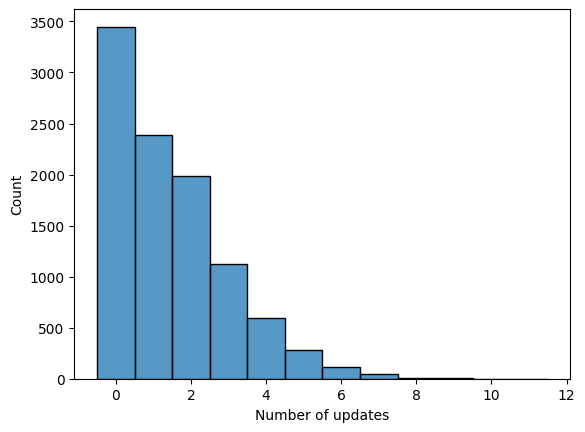

In [27]:
sns.histplot(updates[0].updates, discrete=True);
plt.xlabel("Number of updates");

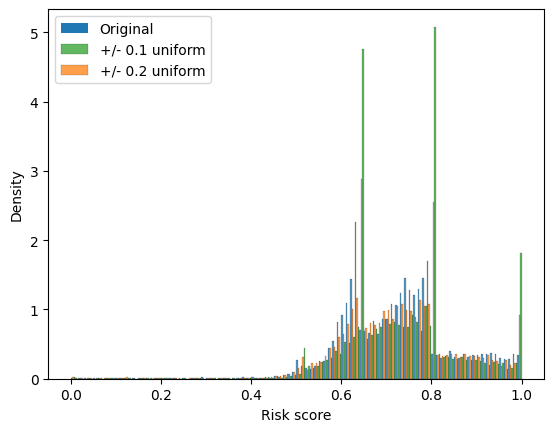

In [38]:
data = updates[0].symptoms
sns.histplot(
    [updates[0].exposures, updates[1].exposures, updates[2].exposures],
    binwidth=0.01,
    stat="density",
    # cumulative=True,
    multiple="dodge",
)
plt.legend(["Original", "+/- 0.1 uniform", "+/- 0.2 uniform"])
plt.xlabel("Risk score");

In [97]:
np.count_nonzero(abs(updates[2].exposures - updates[0].exposures) < 0.2)

8410

# Received

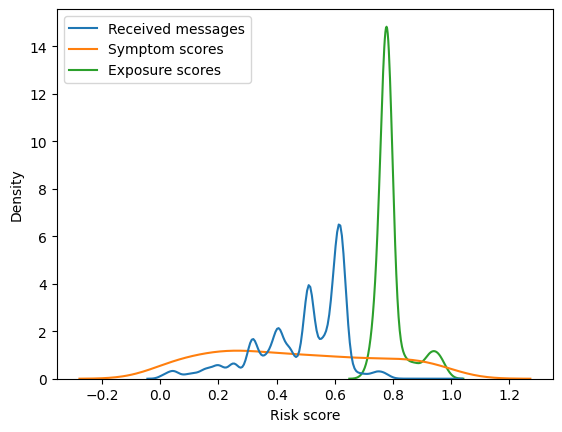

In [8]:
sns.kdeplot({
    "Received messages": received[0].values, 
    "Symptom scores": updates[0].symptoms,
    "Exposure scores": updates[0].exposures},
    common_norm=False);
plt.xlabel("Risk score");

## Timeline

**Note: The timeline of events is influenced by the underlying Akka dispatcher configuration.**

In [105]:
iteration = 0
x_axis = "time"

positions, n_events = plotting.event_plot_positions(timeline[iteration], x_axis=x_axis)
start = positions[2][0]  # First contact msg
end = positions[0][-1]  # Last recevied msg
print(runtime := end - start)

0.607


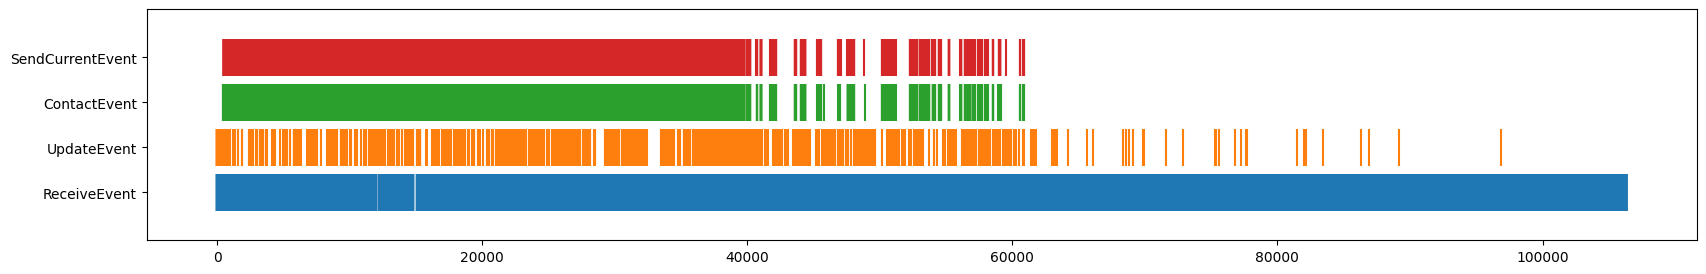

In [14]:
line_len = 5
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(111)
offsets = np.arange(n_events) * (line_len + 1)
ax.axes.set_yticks(offsets)
ax.axes.set_yticklabels(timeline[0].i2e)
ax.eventplot(
    positions,
    colors=[f"C{i}" for i in range(n_events)],
    linelengths=np.repeat(line_len, n_events),
    lineoffsets=np.arange(n_events) * (line_len + 1), 
);

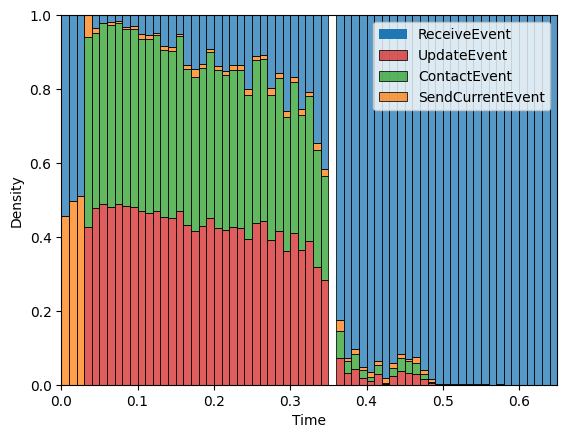

In [106]:
sns.histplot(
    positions, 
    # cumulative=True,
    common_norm=True,
    multiple="fill",
    stat="density",
    binwidth=0.01 if x_axis == "time" else 1000)

plt.legend(timeline[0].i2e);
plt.xlabel(x_axis.capitalize());

## Reachability

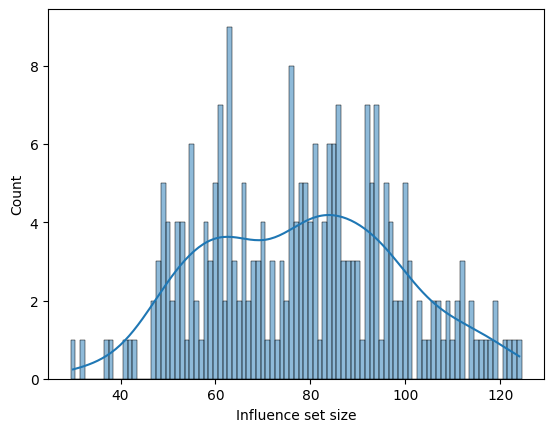

In [68]:
sns.histplot(reachability[0].influence(), discrete=True, kde=True);
plt.xlabel("Influence set size");

In [69]:
reachability[0].reach_ratio()

0.32325319308790385

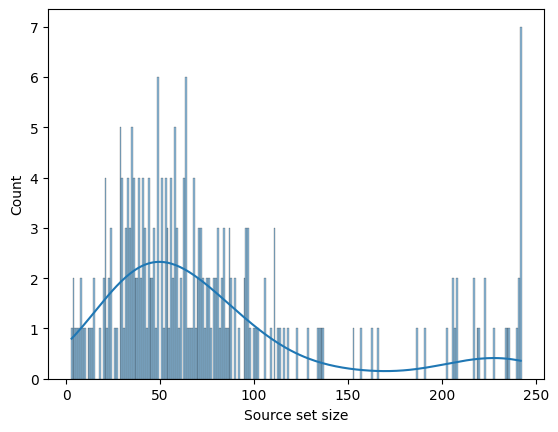

In [70]:
sns.histplot(reachability[0].source_size(), discrete=True, kde=True);
plt.xlabel("Source set size");

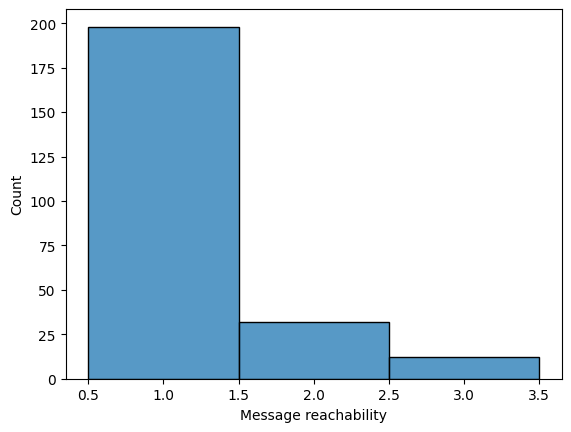

In [71]:
sns.histplot(reachability[0].msg_reach(), discrete=True);
plt.xlabel("Message reachability");

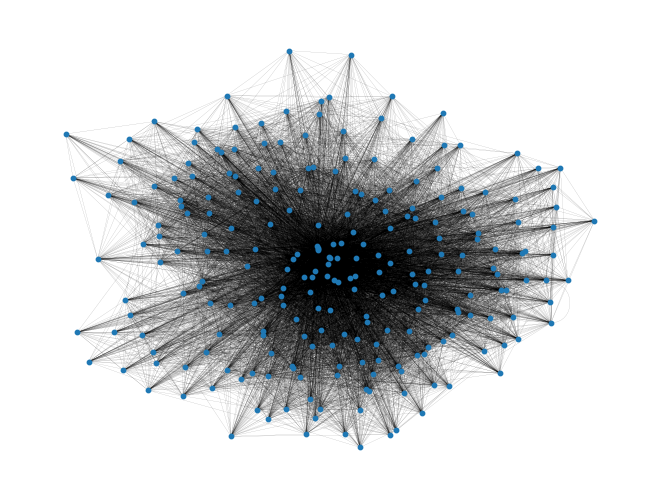

In [72]:
graph = nx.from_scipy_sparse_array(reachability[0].adj)
plt.figure(dpi=100)
nx.draw(
    graph,
    pos=nx.spring_layout(graph),
    width=0.05,
    with_labels=False,
    node_size=10)